# Pipeline

In the training data notebook, I made some basic training data sets. However,

- These only included examples where there was only one radio component
- The code was not very modular (in particular, it was difficult to swap from logistic regression to a convolutional neural network)
- The process was not particularly clear

In this notebook, I will process the Radio Galaxy Zoo images into training pairs step-by-step, and try and make the pipeline explicit and easy to follow.

In [2]:
import collections
import itertools
import logging
import pprint
import sys
import warnings

import matplotlib.pyplot
import numpy
import skimage.feature
import sklearn.cross_validation
import sklearn.linear_model
import sklearn.metrics

sys.path.insert(1, '..')
import crowdastro.data
import crowdastro.rgz_analysis.consensus
import crowdastro.show

%matplotlib inline
warnings.simplefilter('ignore', UserWarning)  # astropy always raises warnings on Windows.

## Filtering out nice examples

The Radio Galaxy Zoo data can be really complicated. To simplify matters, I will start by filtering out nice examples &mdash; examples that only have 1 radio source according to the volunteers' consensus. This means that I can ignore the problem of figuring out which radio emissions are from the same radio source.

First of all, let's get some code from my click_consensus notebook and modify it to return the number of radio sources.

In the below code, a "signature" refers to the unique ID of some combination of radio emissions. An "annotation signature" is the signature associated with what is considered to be a single radio source by a given volunteer, and a "classification signature" is the combination of all signatures chosen by a single volunteer. In this way, a classification signature represents the combination of radio emissions that a volunteer associated with each other. The "plurality classification signature" is the most common classification signature amongst all volunteers.

In [34]:
def make_annotation_signature(annotation):
    """Generates a unique signature from a single radio annotation."""
    if 'radio' not in annotation:
        # Metadata (ignore this).
        return None

    # Having no contours is a special case; () to avoid type errors (it's special but it's still valid!)
    if annotation['radio'] == 'No Contours':
        return ()

    # Round to fix floating point precision loss.
    # Sort to make sure this is deterministic.
    xmaxs = tuple(sorted([round(float(r['xmax']), 14) for r in annotation['radio'].values()]))
    ymaxs = tuple(sorted([round(float(r['ymax']), 14) for r in annotation['radio'].values()]))
    signature = (xmaxs, ymaxs)
    return signature

def make_classification_signature(classification):
    """Generates a unique signature from a complete radio classification."""
    classification_signature = []
    for annotation in classification['annotations']:
        annotation_signature = make_annotation_signature(annotation)
        if annotation_signature is not None:
            classification_signature.append(annotation_signature)

    classification_signature = tuple(sorted(classification_signature))
    return classification_signature

def plurality_classification_signature(subject):
    """Finds the most-chosen radio classification signature for a subject."""
    n_signatures = collections.Counter()
    
    for classification in crowdastro.data.db.radio_classifications.find({'subject_ids': subject['_id']}):
        classification_signature = make_classification_signature(classification)
        n_signatures[classification_signature] += 1

    return max(n_signatures, key=n_signatures.get)

def number_of_radio_sources(subject):
    """Finds the number of radio sources in a subject, according to volunteers."""
    return len(plurality_classification_signature(subject))

Now, we can make a filter for subjects. We want "nice" subjects.

In [4]:
def filter_nice(subjects):
    """Yields nice subjects."""
    for subject in subjects:
        if number_of_radio_sources(subject) == 1:
            yield subject

We also need a source subject generator.

In [5]:
def atlas_subjects():
    """Yields complete ATLAS subjects."""
    return crowdastro.data.db.radio_subjects.find({'metadata.survey': 'atlas', 'state': 'complete'})

We should now be able to join these together and obtain some nice subjects. Let's try it out.

In [6]:
def limit(n, gen):
    """Yield n items from gen."""
    if not hasattr(gen, '__next__'):
        gen = iter(gen)
    for _ in range(n):
        yield next(gen)
            

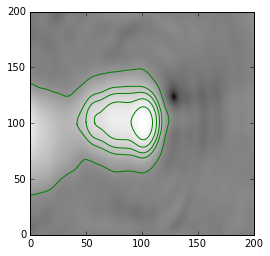

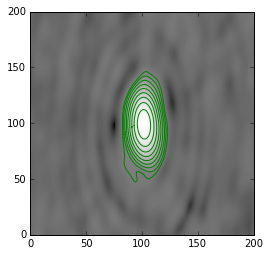

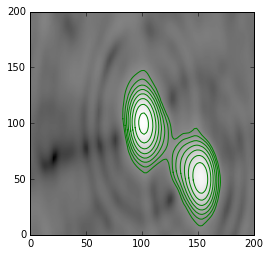

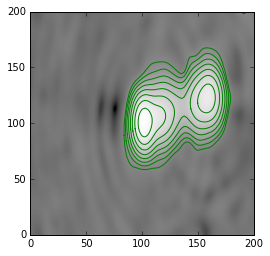

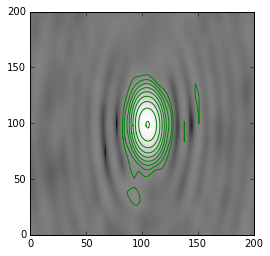

In [7]:
for subject in limit(5, filter_nice(atlas_subjects())):
    crowdastro.show.radio(subject)
    crowdastro.show.contours(subject, colour='green')
    matplotlib.pyplot.xlim((0, 200))
    matplotlib.pyplot.ylim((0, 200))
    matplotlib.pyplot.show()

These mostly seem to be compact sources, which makes sense since those are quite simple. We are now ready to move onto extracting the infrared sources.

## Extracting potential hosts

For each subject, we have an associated infrared (IR) image. This is effectively an image of distant galaxies. We want to find the galaxy that hosts the radio source of each subject. This could be any bright spot in the IR image, so I call these bright spots "potential hosts".

<s>Julie suggested fitting Gaussians to the IR image to detect these potential hosts, but this seems to be quite non-trivial. I've had success in just finding local maxima under some Gaussian blurring, so I'll use this now to write a function that takes a subject generator and yields arrays of (x, y) coordinates of potential hosts.</s>

I've updated this section to use scikit-image's blob detection instead (see notebook 10 for details).

In [30]:
def potential_hosts(subjects):
    """Yields arrays of (x, y) coordinates of potential hosts."""
    for subject in subjects:
        ir = crowdastro.data.get_ir(subject)
        blobs = skimage.feature.blob_log(ir/255, min_sigma=5, max_sigma=15, num_sigma=10, threshold=0.00002,
                                         overlap=0.75, log_scale=False)
        yield numpy.fliplr(blobs[:, :2])

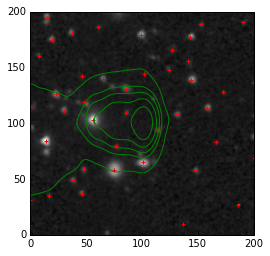

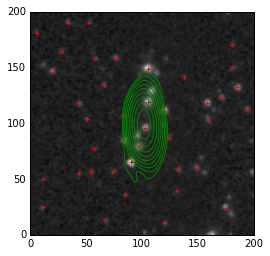

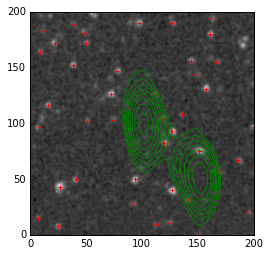

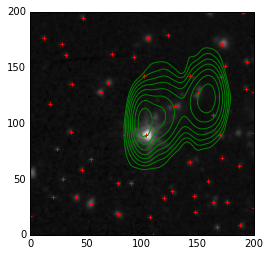

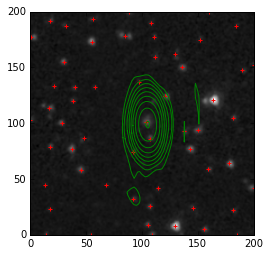

In [32]:
for hosts, subject in limit(5, zip(
        potential_hosts(filter_nice(atlas_subjects())),
        filter_nice(atlas_subjects()))):
    crowdastro.show.ir(subject)
    crowdastro.show.contours(subject, colour='green')
    matplotlib.pyplot.scatter(hosts[:, 0], hosts[:, 1], c='red', marker='+')
    matplotlib.pyplot.xlim((0, 200))
    matplotlib.pyplot.ylim((0, 200))
    matplotlib.pyplot.show()

It's very clear from the plots that there are *way* too many "potential hosts". I'll solve that problem another time. We can now get potential hosts, so let's try and get some representation of the radio emissions around them.

## Potential hosts to radio emissions

From the mean_images notebook, we know that the IR image itself is mostly irrelevant to classification. I want to take a square patch of the radio emissions around each potential host, and then phrase the classification problem as follows: Given this square of radio emissions, is the host of the emissions in the centre?

I'll write a generator that takes subjects and yields arrays of square radio images around each potential host. I'll call these squares "potential host radio neighbourhoods".

In [35]:
def potential_host_radio_neighbourhoods(subjects, radius=20):
    """Yields arrays of radio neighbourhoods around potential hosts."""
    subjects, subjects_clone = itertools.tee(subjects)
    hosts_gen = potential_hosts(subjects_clone)
    
    for subject, hosts in zip(subjects, hosts_gen):
        # Fetch the large image - that way, we don't need to impose artificial restrictions on the edges of the image.
        radio = crowdastro.data.get_radio(subject, size='5x5')
        
        # Get neighbourhoods around each host.
        neighbourhoods = []
        # Distance from edge of large image to edge of small image.
        border_radius = (crowdastro.config.get('fits_image_width') * 5 // 2 - crowdastro.config.get('fits_image_width')) // 2
        for host_x, host_y in hosts:
            host_x, host_y = int(host_x), int(host_y)
            neighbourhood = radio[border_radius + host_x - radius : border_radius + host_x + radius,
                                  border_radius + host_y - radius : border_radius + host_y + radius]
            neighbourhoods.append(neighbourhood)
        
        yield numpy.array(neighbourhoods)

Let's try it out. We'll take a look at some neighbourhoods.

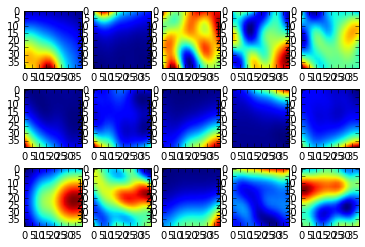

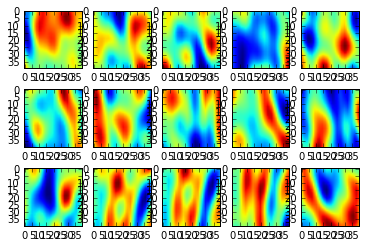

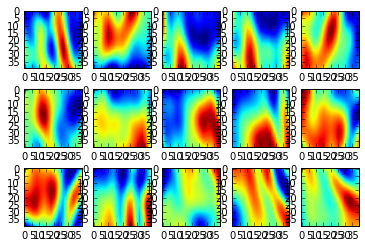

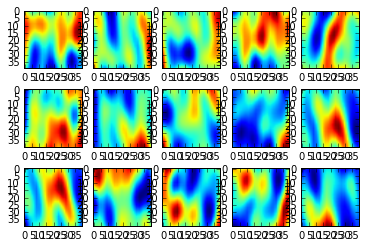

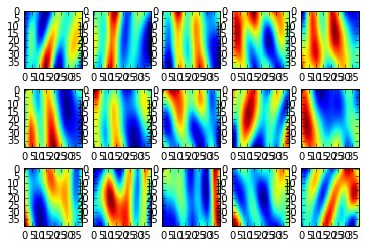

In [36]:
for neighbourhoods in limit(5, potential_host_radio_neighbourhoods(filter_nice(atlas_subjects()))):
    for idx, neighbourhood in zip(range(15), neighbourhoods):
        matplotlib.pyplot.subplot(3, 5, idx + 1)
        matplotlib.pyplot.imshow(neighbourhood)
    
    matplotlib.pyplot.show()

## Potential hosts to classifications

I'm treating each potential host as a binary classification problem. Every potential host is either $0$ (not the host) or $1$ (the host). I'll write a generator that takes subjects and yields lists of classifications. To do this, I'll also need to have a way to find which host is the "correct" host according to the volunteers. For now, I'll use Kyle Willett's Radio Galaxy Zoo code; later, I'll swap that for my faster method.

In [70]:
def potential_host_classifications(subjects):
    """Yields array of classifications of potential hosts."""
    subjects, subjects_clone = itertools.tee(subjects)
    hosts_gen = potential_hosts(subjects_clone)

    for subject, hosts in zip(subjects, hosts_gen):
        consensus = crowdastro.rgz_analysis.consensus.consensus(subject['zooniverse_id'])
        answers = list(consensus['answer'].values())
        
        classifications = numpy.zeros(hosts.shape[0])
        
        if len(answers) != 1:
            # My plurality radio combination differs from Kyle Willett's - odd, but does happen.
            # Haven't solved this yet, so we'll take the noise hit for now and ignore the problem.
            logging.warning('Ignoring a subject due to unexpected number of answers ({}).'.format(len(answers)))
            yield classifications
            continue

        if 'ir_peak' in answers[0]:
            true_host = numpy.array(answers[0]['ir_peak']) * 200 / 500  # Magic constant from web -> fits.
            true_host[1] = crowdastro.config.get('fits_image_height') - true_host[1]  # Clicks are flipped vertically.
        elif 'ir' in answers[0]:
            true_host = numpy.array(answers[0]['ir']) * 200 / 500
            true_host[1] = crowdastro.config.get('fits_image_height') - true_host[1]  # Clicks are flipped vertically.
        else:
            logging.warning('No click peaks found.')
            yield classifications  # Not sure what causes this case, but there are no click peaks.
            continue
        
        # Find the potential host closest to the true host. This is labelled 1; all else labelled 0.
        classifications[numpy.array([numpy.linalg.norm(diff) for diff in hosts - true_host]).argmin()] = 1
        yield classifications

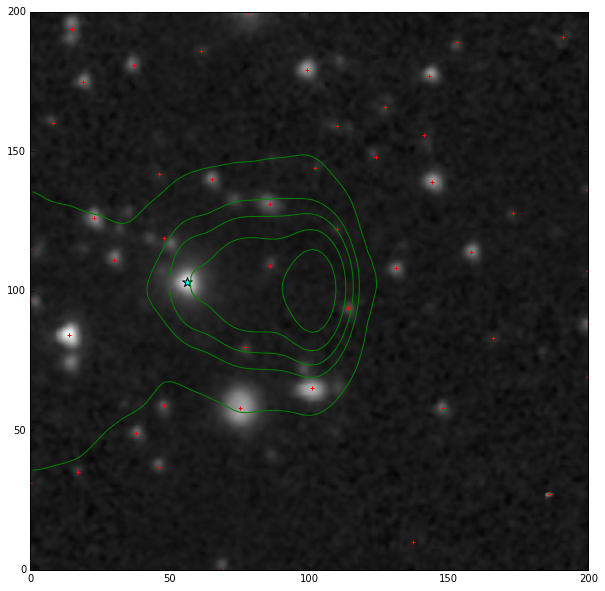

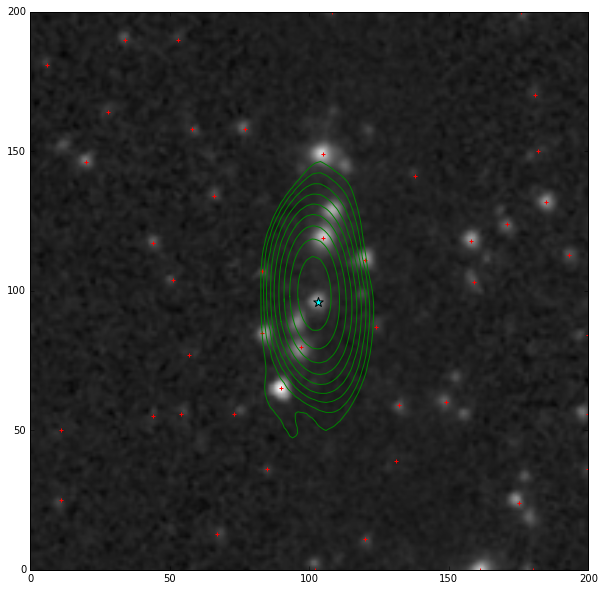

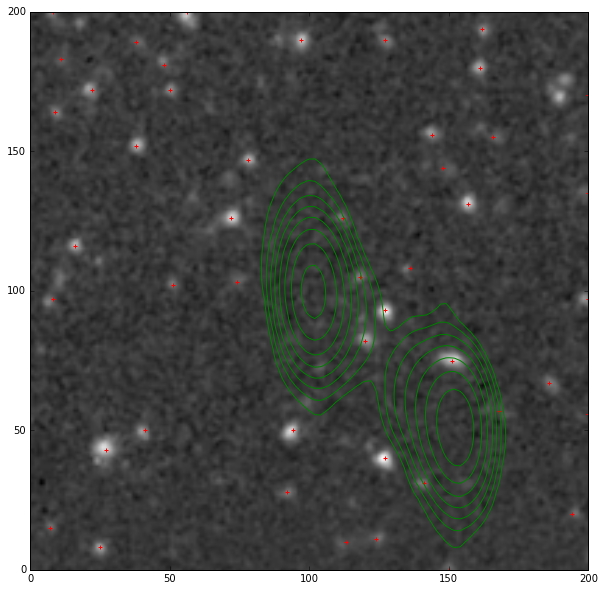

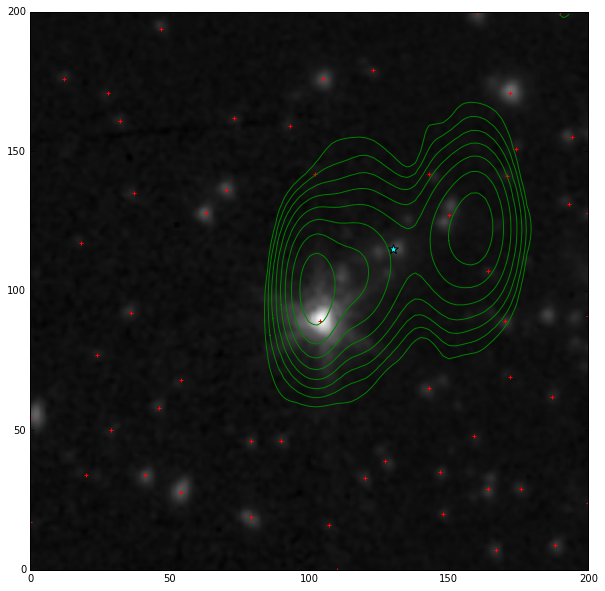

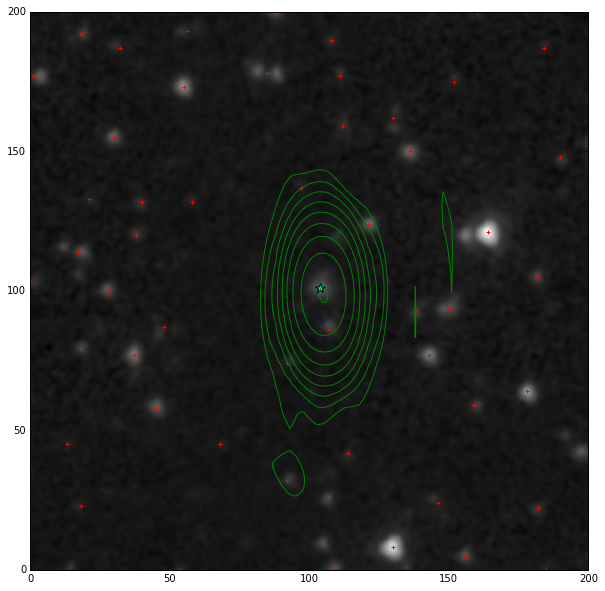

In [72]:
for subject, hosts, classifications in limit(5, zip(
        filter_nice(atlas_subjects()),
        potential_hosts(filter_nice(atlas_subjects())),
        potential_host_classifications(filter_nice(atlas_subjects())))):
    matplotlib.pyplot.figure(figsize=(10, 10))
    matplotlib.pyplot.xlim((0, 200))
    matplotlib.pyplot.ylim((0, 200))
    crowdastro.show.ir(subject)
    crowdastro.show.contours(subject, colour='green')
    pos_hosts = hosts[classifications == 1]
    neg_hosts = hosts[classifications == 0]
    matplotlib.pyplot.scatter(neg_hosts[:, 0], neg_hosts[:, 1], c='r', marker='+')
    matplotlib.pyplot.scatter(pos_hosts[:, 0], pos_hosts[:, 1], c='cyan', marker='*', s=100)
    matplotlib.pyplot.show()

One questionable decision there, but on the whole it seems to work. Now we can put the whole pipeline together and get some training pairs!

## Training pairs

A training pair is an $(x, t)$ tuple, where $x$ is the input and $t$ is our desired output. In this case, $x \in \mathbb{R}^{200 \times 200}$ is a radio neighbourhood, and $t \in \{0, 1\}$ is the classification. We want to find a map from the former to the latter.

To find training pairs, I will make a generator.

In [73]:
def training_pairs(subjects):
    """Yields (radio neighbourhood, classification) training pairs."""
    subjects, subjects_clone = itertools.tee(subjects)
    
    all_neighbourhoods = potential_host_radio_neighbourhoods(subjects)
    all_classifications = potential_host_classifications(subjects_clone)
    
    for neighbourhoods, classifications in zip(all_neighbourhoods, all_classifications):
        for neighbourhood, classification in zip(neighbourhoods, classifications):
            yield (neighbourhood, classification)

Let's try it out.

Classification: 0.0


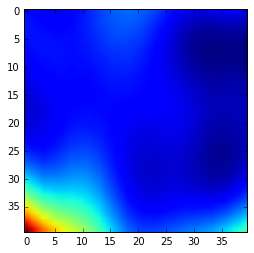

Classification: 0.0


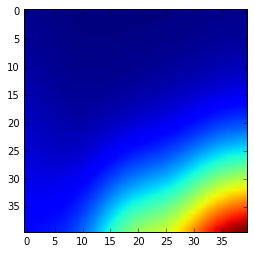

Classification: 0.0


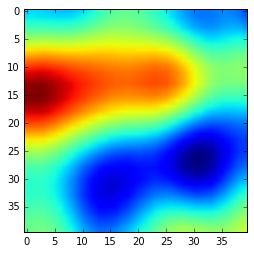

Classification: 1.0


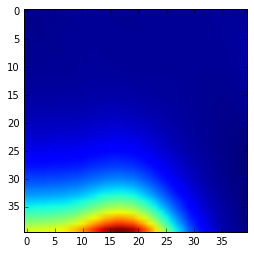

Classification: 0.0


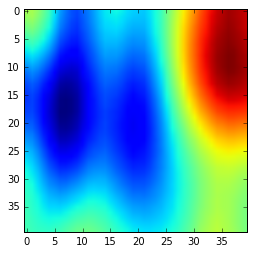

Classification: 0.0


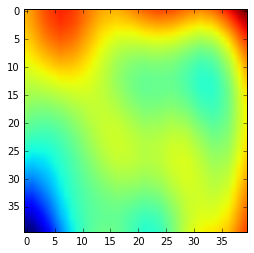

Classification: 0.0


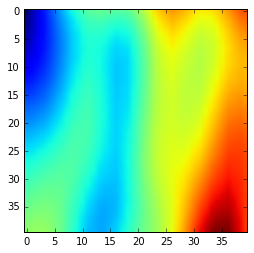

Classification: 0.0


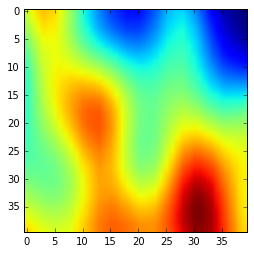

Classification: 1.0


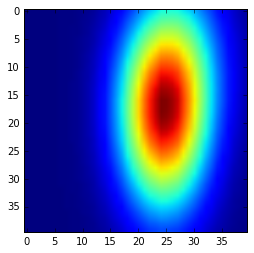

Classification: 0.0


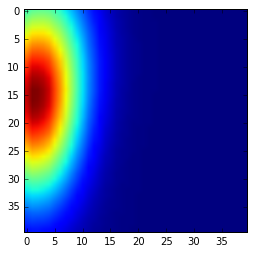

Classification: 0.0


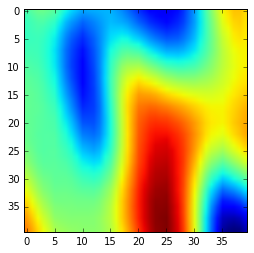

In [74]:
for radio, classification in limit(100, training_pairs(filter_nice(atlas_subjects()))):
    if classification != 1:
        if numpy.random.random() > 0.1:
            continue
    print('Classification:', classification)
    matplotlib.pyplot.imshow(radio)
    matplotlib.pyplot.show()

I certainly can't tell the difference. Let's hope the computer can! Now, let's put everything into logistic regression and see how we go.

## Test: Logistic regression

I need some more helper functions &mdash; specifically, I need an array of $x$s and an array of $t$s.

In [128]:
def get_training_data(n, training_subjects=None):
    """Gets n training data pairs.
    
    n: Number of example subjects.
    training_subjects: Optional. If specified, use this generator to retrieve training subjects.
    -> Array of examples, array of targets.
    """
    if training_subjects is None:
        logging.info('Generating new training subjects.')
        training_subjects = filter_nice(atlas_subjects())

    xs = []
    ts = []
    for x, t in limit(n, training_pairs(training_subjects)):
        xs.append(x.flatten())
        ts.append(t)
    
    return numpy.array(xs), numpy.array(ts)

Now we can throw things into logistic regression pretty easily.

In [129]:
def logistic_regression(n, print_confusion=False, training_subjects=None):
    """Trains logistic regression on n example subjects.
    
    n: Number of example subjects.
    print_confusion: Optional, default False. Prints confusion matrix.
    training_subjects: Optional. If specified, use this generator to retrieve training subjects.
    -> Logistic regression
    """
    xs, ts = get_training_data(n, training_subjects=training_subjects)
    xs_train, xs_test, ts_train, ts_test = sklearn.cross_validation.train_test_split(xs, ts, test_size=0.2, random_state=1)
    
    lr = sklearn.linear_model.LogisticRegression(C=1e5, class_weight='balanced')
    lr.fit(xs_train, ts_train)
    
    if print_confusion:
        pprint.pprint(sklearn.metrics.confusion_matrix(ts_test, lr.predict(xs_test)))
    
    return lr

In [130]:
logistic_regression(1000, print_confusion=True)

array([[145,  49],
       [  2,   4]])


LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

|                       | predicted non-host | predicted host |
|-----------------------|--------------------|----------------|
| **actually non-host** | 1396               | 556            |
| **actually host**     | 7                  | 41             |

It would be interesting to see what the probability outputs are for each class. It might be possible that the actual host has a higher "score" than non-hosts that are still predicted to be hosts.

I still need to be able to input a subject and receive back which potential host has the highest probability of being the true host. I'll write a function that takes some subjects and yields the predicted host $(x, y)$ coordinates of their hosts.

In [122]:
def predict_hosts(subjects, training_subjects=None):
    lr = logistic_regression(1000, training_subjects=training_subjects)
    subjects, subjects_clone_1, subjects_clone_2 = itertools.tee(subjects, 3)

    all_neighbourhoods = potential_host_radio_neighbourhoods(subjects_clone_1)
    all_potential_hosts = potential_hosts(subjects_clone_2)

    for neighbourhoods, hosts, subject in zip(all_neighbourhoods, all_potential_hosts, subjects):
        neighbourhoods = neighbourhoods.reshape((neighbourhoods.shape[0], -1))
        probabilities = lr.predict_proba(neighbourhoods)
        predicted_host = hosts[probabilities[:, 1].argmax()]
        yield predicted_host

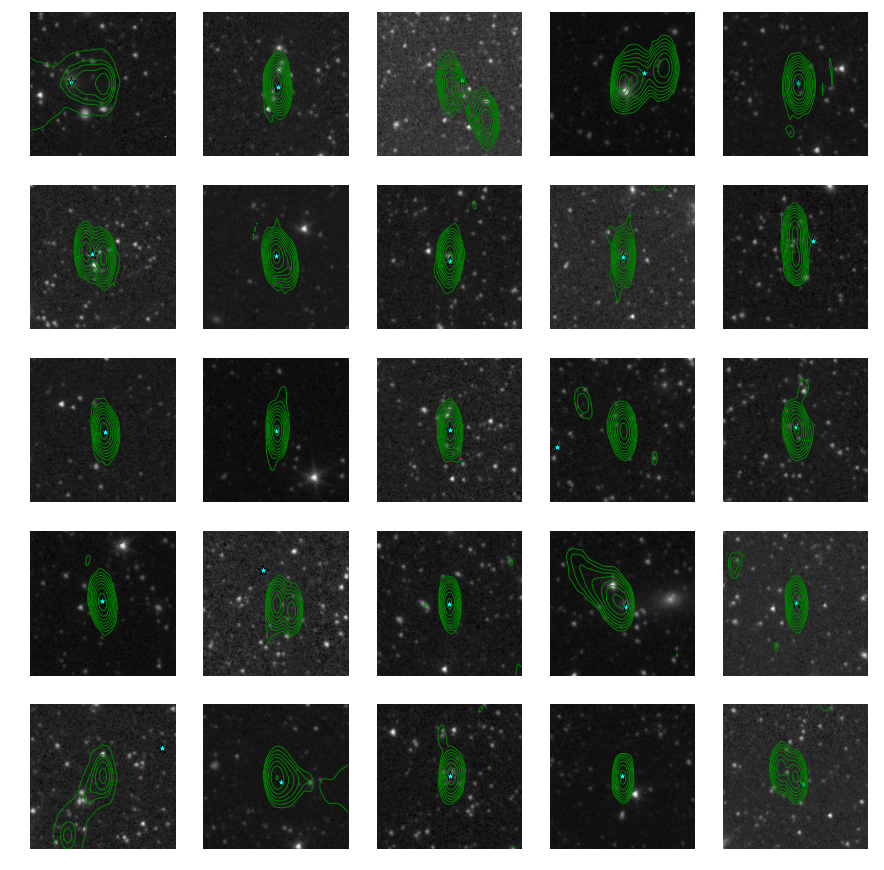

In [111]:
matplotlib.pyplot.figure(figsize=(15, 15))
for idx, subject, host in zip(
        range(25),
        filter_nice(atlas_subjects()),
        predict_hosts(filter_nice(atlas_subjects()))):
    matplotlib.pyplot.subplot(5, 5, idx + 1)
    matplotlib.pyplot.axis('off')
    matplotlib.pyplot.xlim((0, 200))
    matplotlib.pyplot.ylim((0, 200))
    crowdastro.show.ir(subject)
    crowdastro.show.contours(subject, colour='green')
    matplotlib.pyplot.scatter([host[0]], [host[1]], c='cyan', marker='*', s=100)
matplotlib.pyplot.show()

This is not too bad. It seems that sometimes the maximally bright radio point will be chosen when the true host galaxy is elsewhere &mdash; this is probably due to how many compact sources there are.

I'm wary that I don't know for sure that the test set I'm using above is separated from the training set as the pipeline here doesn't allow it, but I will take care of that in future.

I'll run this on a few hundred examples and get some accuracy percentages out. To do this, I'll have to make sure I don't reuse test data - I know that the classifier will happily overfit this data from my earlier experiments. To do that, I'll first draw out my test data, then use the rest of the data as training data.

In [131]:
n_total = 0
n_correct = 0
subjects = filter_nice(atlas_subjects())
nice = [next(subjects) for _ in range(100)]
for hosts, classifications, predicted_host in zip(
        potential_hosts(nice),
        potential_host_classifications(nice),
        predict_hosts(nice, training_subjects=subjects)):
    if (classifications == 0).all():
        continue

    true_host = hosts[classifications.argmax()]
    if numpy.allclose(true_host, predicted_host):
        n_correct += 1
    n_total += 1

print('Accuracy: {:.02%}'.format(n_correct / n_total))

Accuracy: 48.45%


This is surprisingly high for such a simple approach! I wonder if there are ~50% compact sources.